-0.10231221343023138
0.11809565501532723
0.499750124937531


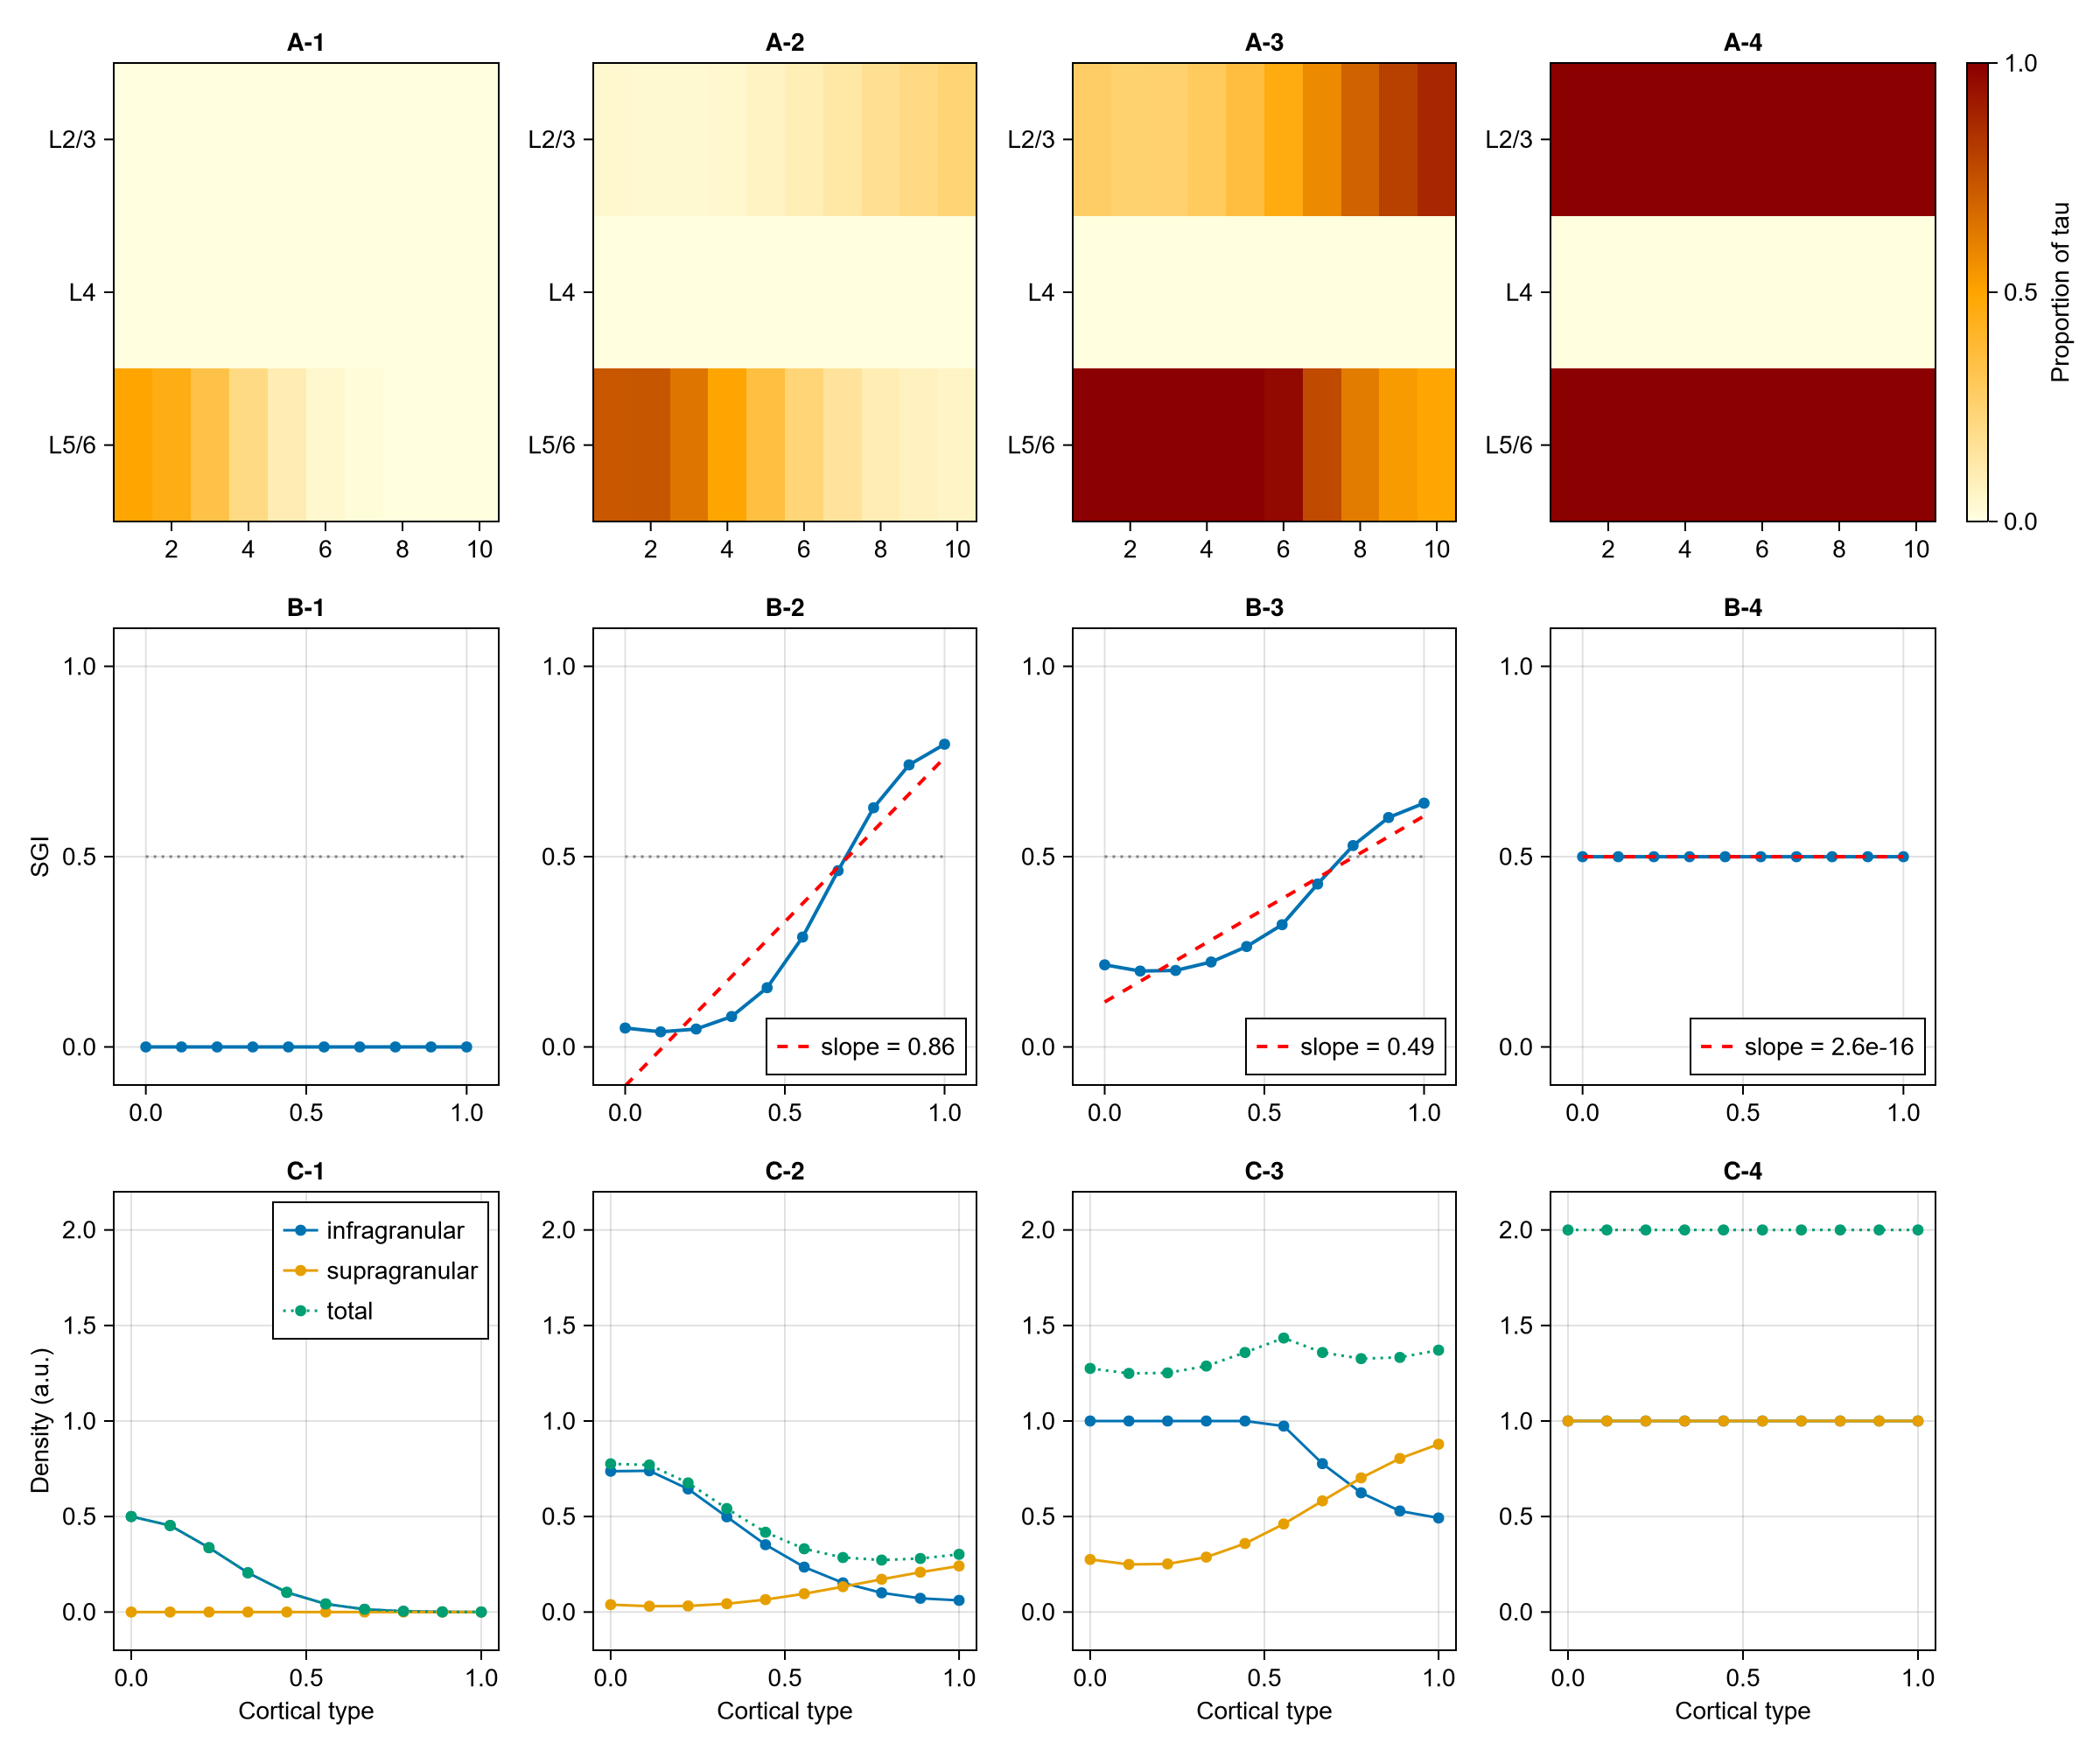

In [ ]:
using CairoMakie, Random, LinearAlgebra

Ncortices = 10
Ctype = LinRange(0,1,Ncortices)

Ctx = zeros(3,Ncortices)

infra = 1
supra = 3

# Presence of tau in first cortical area 

#Ctx[infra,:] = max.(LinRange(0.1,0.0,Ncortices),0)
Ctx[infra,:] .= 0.5 .* exp.(-0.5 .* (Ctype ./ 0.25 ) .^2)
#Ctx[supra,1] =0.0

# Range of cortical types
#Ctype = LinRange(1,Ncortices,Ncortices)

pset = []

function csim(d,sigma)
    #return max.(1-d,0)
    return exp(-0.5*(d/sigma)^2)
end

# Connection strength function
function W(receiver::Float64, sender::Float64)
    M = zeros(3,3)

    amp = 0.02  
    
    M[infra,supra] = amp * (1 - csim(sender - receiver, 0.25))
    M[supra,infra] = amp * (1 - csim(sender - receiver, 0.7))
    
    #M[infra,infra] = amp * csim(sender - receiver, 0.25)
    #M[supra,supra] = amp * csim(sender - receiver, 0.25)

    return M
end

toshow = [1 10 20 30]
t = 0
hmaps = []
trends = []
trendinfras = []
trendsupras = []
densities = []
cmax = 0.0
dmax = 0.0
for i = 1:toshow[end]
    global t, cmax, dmax, hmaps, trends, trendinfras, trendsupras, densities

    if i in toshow
        t = t + 1
        cmax = max(maximum(Ctx),cmax)

        push!(hmaps, deepcopy(Ctx'))

        trend = Ctx[3,:] ./ (Ctx[1,:] .+ Ctx[3,:] .+ 0.001)
        trendinfra = Ctx[infra,:]
        trendsupra = Ctx[supra,:]

        push!(trends,trend)
        push!(trendinfras,trendinfra)
        push!(trendsupras,trendsupra)
        density = Ctx[3,:] .+ Ctx[1,:]
        dmax = max(maximum(density),dmax)
        push!(densities,density)
    end

    # Spread of tau per time step
    for r = 1:Ncortices
        for s = 1:Ncortices
            if s!=r
                #Ctx[:,r] = Ctx[:,r] .+ 0.5.*(1.0 .- Ctx[:,r]) .* (W(Ctype[r],Ctype[s])*Ctx[:,s])
                
                Ctx[:,r] = Ctx[:,r] .+   (W(Ctype[r],Ctype[s]) * Ctx[:,s] ) # linear growth of tau
                
                #Ctx[:,r] = Ctx[:,r] .+  (W(Ctype[r],Ctype[s]) * max.(Ctx[:,s] .- 10,0)) # linear growth of tau
                
                Ctx .= min.(Ctx,1) #upper threshold
            end
        end
    end
 end

fig = Figure(size = (1200, 1000), fonts = (; regular = "Arial"))

for t in 1:length(toshow)
    global cmax, dmax, hmaps, trends, densities
    
    ax = Axis(fig[1, t], yticks = (1:3, ["L5/6", "L4", "L2/3"]))
    heatmap!(ax,  hmaps[t], colormap = :heat, colorrange=(0.0,cmax))
    
    if t==1
        ax2 = Axis(fig[2, t], ylabel = "SGI")
    else
        ax2 = Axis(fig[2, t])

        # Add a column of ones for the intercept term

    end

    lines!(ax2, Ctype,0.5 .* ones(Ncortices),linestyle = :dot, color = :gray)
    scatterlines!(ax2,Ctype,trends[t], linewidth = 2)

    if t != 1
        X = hcat(ones(length(Ctype)), Ctype)

        # Solve for coefficients [intercept, slope]
        coefficients = X \trends[t]
        println(coefficients[1])
        
        slope =  round(coefficients[2], sigdigits=2)  
        lines!(ax2, Ctype,coefficients[2].*Ctype .+ coefficients[1], linewidth = 2, linestyle = :dash, color = :red, label = "slope = $slope")
        axislegend(position = :rb)
    end

    ylims!(ax2,-0.1,1.1)
    xlims!(ax2,-0.1,maximum(Ctype) + 0.1)
    if t==1
        ax3 = Axis(fig[3, t], xlabel = "Cortical type", ylabel = "Density (a.u.)")

    else
        ax3 = Axis(fig[3, t], xlabel = "Cortical type")
    end
    
    scatterlines!(ax3,Ctype, trendinfras[t], label = "infragranular")
    scatterlines!(ax3,Ctype, trendsupras[t], label = "supragranular")
    scatterlines!(ax3,Ctype, densities[t], linestyle = :dot, label = "total")

    ylims!(ax3,-0.2,1.1*dmax)
    
    if t==1
        axislegend()
    end

    ax.title = "A-" * string(t)
    ax2.title = "B-" * string(t)
    ax3.title = "C-" * string(t)
    end



mx = maximum(Ctx)
cb = Colorbar(fig[1, 5]; colorrange=(0.0,cmax), label = "Proportion of tau", colormap = :heat)
fig

#save("CTE_SimResult_Original2.png", fig; pt_per_unit=1)
#save("CTE_SimResult.tif", fig; pt_per_unit=1)